In [1]:
import pandas as pd, numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
train = pd.read_csv('Downloads/Toxic comment Dataset/train.csv')
test = pd.read_csv('Downloads/Toxic comment Dataset/test.csv')

In [3]:
train.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


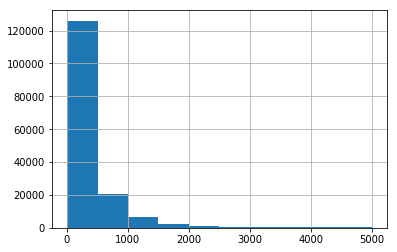

In [4]:
# check how skewed the length of the comments is across the dataset
lens = train.comment_text.str.len()
lens.hist()
plt.show()

In [5]:
# checking for nullvalues
# train.isnull().any()
print('train size = {}, test size = {}'.format(train.shape, test.shape))

train size = (159571, 8), test size = (153164, 2)


In [6]:
# train.comment_text.isnull().any()
# let's just ensure that there is no null here :)
train.comment_text.fillna(' ', inplace=True)
test.comment_text.fillna(' ', inplace=True)

In [7]:
train.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [8]:
class_names = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']

In [9]:
trainText = train['comment_text']
testText = test['comment_text']
# trainText[0]

In [10]:
# train.toxic.value_counts() 15294
# train.severe_toxic.value_counts()       1595
# train.obscene.value_counts()   8449
# train.threat.value_counts() 478
# train.insult.value_counts()  7877
# train.identity_hate.value_counts()  1405

In [11]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(stop_words='english',max_features=100000,analyzer='word'
                       ,strip_accents='unicode',token_pattern=r'\w{1,}')

# vect = TfidfVectorizer(
#   sublinear_tf=True,
#     strip_accents='unicode',
#     analyzer='word',
#     token_pattern=r'\w{1,}',
#     stop_words='english',
#     ngram_range=(1, 1),
#     max_features=100)


In [12]:
train_dtm = vect.fit_transform(trainText)
train_dtm

<159571x100000 sparse matrix of type '<class 'numpy.int64'>'
	with 4132539 stored elements in Compressed Sparse Row format>

In [28]:
# vect.get_feature_names()

In [15]:
# df_train_dtm = pd.DataFrame(train_dtm.toarray(), columns=vect.get_feature_names())
# the above code gets me a memory error, unfortunately wasnt able to figure a way out around this smoothly

In [16]:
# deal with the numbers in the features kasia bhi

In [17]:
trainLabels = train[class_names]
trainLabels.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0,0,0,0,0,0
1,0,0,0,0,0,0
2,0,0,0,0,0,0
3,0,0,0,0,0,0
4,0,0,0,0,0,0


In [18]:
# let's try to check the comments with no toxicity whatsoever
trainLabels['clean'] = 1 - trainLabels.sum(axis=1) >= 1  

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [19]:
kinds, counts = zip(*trainLabels.sum(axis=0).items())

<BarContainer object of 7 artists>

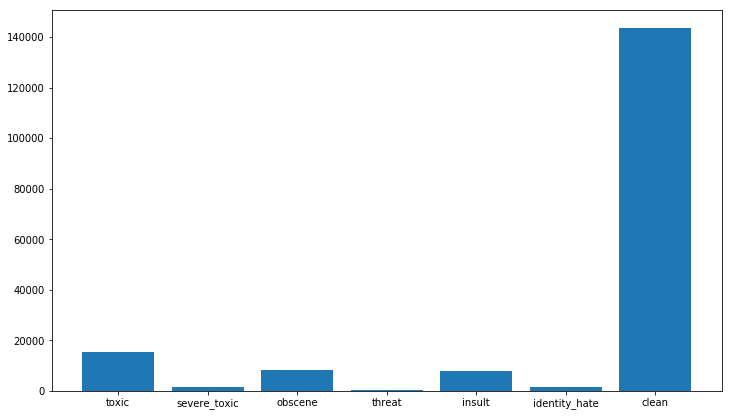

In [20]:
plt.figure(figsize=(12, 7))
plt.bar(kinds, counts)

In [21]:
#it is clearly evident that there is some sort of profanity in the comments, however see the count of 'clean'. 

In [22]:
# transforming the text data from test dataset
test_dtm = vect.transform(testText)

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score

In [24]:
scores = []

sub = pd.DataFrame.from_dict({'id': test['id']})

for class_name in class_names:
    train_target = train[class_name]
    model = LogisticRegression()  

    cv_score = np.mean(cross_val_score(model, train_dtm, train_target, cv=4, scoring='roc_auc'))
    scores.append(cv_score)
    print('CV score for class {} is {}'.format(class_name, cv_score))

    model.fit(train_dtm, train_target)
    sub[class_name] = model.predict_proba(test_dtm)[:, 1]

CV score for class toxic is 0.9517932763775798
CV score for class severe_toxic is 0.9534073128568475
CV score for class obscene is 0.9630540207273603
CV score for class threat is 0.952147815590194
CV score for class insult is 0.9411680911300544
CV score for class identity_hate is 0.9065228337578686


In [25]:
print('Total CV score is {}'.format(np.mean(scores)))

Total CV score is 0.9446822250733176


In [27]:
sub.to_csv('sub1.csv', index=False)